![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# Conditional GAN con Pytorch


En este cuaderno, vamos a construir una GAN condicional para generar imágenes manuscritas de dígitos, condicionando el dígito a generar (el vector de clase). Esto te permitirá **elegir** qué dígito quieres generar.

Luego se hará una exploración de las imágenes generadas para visualizar lo que significan los vectores ruido y clase.  

### Objetivos
1.   Aprender la diferencia técnica entre un GAN condicional y uno incondicional.
2.   Entender la distinción entre el vector clase y el vector ruido en un GAN condicional.



## Detalles de diseño

Para esta tarea, volvemos a utilizar el conjunto de datos MNIST, aunque nada le impide aplicar este código generador para producir imágenes de animales condicionadas a la especie o imágenes de caras condicionadas a las características faciales.

Detalles muy iportantes en la implementación de esta GAN condicional:

+ **no requiere cambios** en las arquitecturas del generador o del discriminador, sólo cambios en los datos que se pasan a ambos.
+ El generador ya no tomará `z_dim` como argumento, sino `input_dim` en su lugar, ya que necesita pasar tanto los vectores de ruido como los de clase.

Teniendo en cuenta estos detalles, esto también significa que podemos utilizar el generador y el código discriminador que ha escrito previamente pero con **diferentes parámetros**.

Empezarás importando las librerías necesarias y construyendo el generador y el discriminador.

## Importaciones y funciones auxiliares

In [19]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!



In [20]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

## Generador y Ruido

In [21]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)



In [22]:
def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

## Discriminador

In [23]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Clase de Entrada

En las GAN condicionales, el vector de entrada para el generador también deberá **incluir** la información de clase. La clase se representa mediante un vector codificado de un punto en el que su longitud es el número de clases y cada índice representa una clase. El vector es todo 0 y un 1 en la clase elegida: *One Hot Encoding* (OHE)

Dadas las etiquetas de varias imágenes (por ejemplo, de un lote) y el número de clases, cree vectores OHE para cada etiqueta. Hay una clase dentro de la biblioteca funcional PyTorch que puede ayudarle

<details>

<summary>
<font size="3" color="green">
<b>Pista opcional para <code><font size="4">get_one_hot_labels</font></code></b>
</font>
</summary>

1.   Esa operación se puede hacer en una línea de código.
2.   La documentación de [F.one_hot](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.one_hot) será útil.

</details>


In [24]:
# C1: Completa el código donde corresponde:

import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    #### START CODE HERE ####
    return F.one_hot(labels, n_classes)
    #### END CODE HERE ####

In [25]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
assert (
    get_one_hot_labels(
        labels=torch.Tensor([[0, 2, 1]]).long(),
        n_classes=3
    ).tolist() ==
    [[
      [1, 0, 0],
      [0, 0, 1],
      [0, 1, 0]
    ]]
)
print("Success!")

Success!


A continuación, hay que concatenar el vector de una clase con el vector de ruido antes de dárselo al generador. También habrá que hacer esto cuando añada los canales de clase al discriminador.

Para ello, vamos a definir una función que combine dos vectores. Recuerda que debes asegurarte de que los vectores son del mismo tipo: floats. De nuevo, puedes buscar ayuda en la librería PyTorch.

<details>
<summary>
<font size="3" color="green">
<b>Pista opcional para <code><font size="4">combine_vectors</font></code></b>
</font>
</summary>

1.   Este código tambien puede ser escrito en una sola línea
2.   La documentación de  [torch.cat](https://pytorch.org/docs/master/generated/torch.cat.html) será de ayuda... ;).
3.   Presta especial atención a lo que hace el argumento `dim` de `torch.cat`.

</details>


In [26]:
# C2: Completa el código donde corresponde:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector.
        In this assignment, this will be the noise vector of shape (n_samples, z_dim),
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    #### START CODE HERE ####
    combined = torch.cat((x.float(), y.float()), 1)
    #### END CODE HERE ####
    return combined

In [27]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
combined = combine_vectors(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[5, 6], [7, 8]]));
# Check exact order of elements
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]]))
# Tests that items are of float type
assert (type(combined[0][0].item()) == float)
# Check shapes
combined = combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5));
assert tuple(combined.shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)
print("Success!")

Success!


## Entrenamiento
Vamos a ponerlo todo junto.
Primero definimos algunos parámetros nuevos:

* mnist_shape: el número de píxeles de cada imagen MNIST, que tiene unas dimensiones de 28 x 28 y un canal (porque es en blanco y negro), así que 1 x 28 x 28
* n_classes: el número de clases en MNIST (10, ya que están los dígitos del 0 al 9)

In [28]:
mnist_shape = (1, 28, 28)
n_classes = 10

Y por supuesto los parámetros que ya hemos usado en los diseños anteriores:

  * Criterion: la función de pérdida
  * n_epochs: el número de veces que se itera a través de todo el conjunto de datos durante el entrenamiento
  * z_dim: la dimensión del vector de ruido
  * display_step: frecuencia de visualización de las imágenes
  * batch_size: número de imágenes por pasada hacia delante/hacia atrás
  * lr: la tasa de aprendizaje
  * dispositivo: tipo de dispositivo (CPU, GPU)




In [29]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

A continuación, hay que inicializar el generador, el discriminador y los optimizadores. Para ello, es necesario actualizar las dimensiones de entrada para ambos modelos.
+ Para el generador, tendrá que calcular el tamaño del vector de entrada; recuerde que para los GAN condicionales, la entrada del generador es el vector de ruido concatenado con el vector de clase.
+ Para el discriminador, hay que añadir un canal para cada clase.

In [30]:
# C3: Completa el código donde corresponde:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns:
        generator_input_dim: the input dimensionality of the conditional generator,
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [31]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
def test_input_dims():
    gen_dim, disc_dim = get_input_dimensions(23, (12, 23, 52), 9)
    assert gen_dim == 32
    assert disc_dim == 21
test_input_dims()
print("Success!")

Success!


In [32]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Now to train, you would like both your generator and your discriminator to know what class of image should be generated. There are a few locations where you will need to implement code.

For example, if you're generating a picture of the number "1", you would need to:
  
1.   Tell that to the generator, so that it knows it should be generating a "1"
2.   Tell that to the discriminator, so that it knows it should be looking at a "1". If the discriminator is told it should be looking at a 1 but sees something that's clearly an 8, it can guess that it's probably fake

There are no explicit unit tests here -- if this block of code runs and you don't change any of the other variables, then you've done it correctly!

In [34]:
# C4: Completa el código donde corresponde:

# (NOTE: 80.000 steps aprox. 3h in A100GPU - 40iu)
# (60.000/128)*200= 93750 steps total training

cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images

        #### START CODE HERE ####
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        #### END CODE HERE ####

        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels,
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred

        #### START CODE HERE ####
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
        #### END CODE HERE ####

        # Make sure shapes are correct
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)


        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

/home/vic_263/anaconda3/envs/ia/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 2/469 [00:00<02:30,  3.10it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


 50%|████▉     | 234/469 [00:16<00:16, 14.40it/s]


KeyboardInterrupt: 

##Salvar los modelos

Es importante salvar los modelos para poder recuperarlos.


In [35]:
# First time (at least) we can(must) save the models trained
torch.save(gen.state_dict(), 'Conditional_GAN_MNIST_Gen.pt')
torch.save(disc.state_dict(), 'Conditional_GAN_MNIST_Disc.pt')


En concreto estos modelos han sido salvados, por lo que puedes interrumpir u omitir el entrenamiento si es muy largo y cargar los modelos que se han suministrado. (Ir al apartado "Cargar y probar modelos")

## Exploración
Vamos a ver un poco de exploración con interpolaciones y variaciones en el espacio latente Z (ruido).

In [36]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

#### Cambiar el vector de clase
¡Podemos generar algunos números con el nuevo modelo!
No solo podemos indicar la clase que queremos obtener, sino que también podemos añadir **interpolación** para hacerlo más interesante.

Así, partiendo de una imagen, se producen imágenes intermedias que se parecerán cada vez más a la imagen final hasta que llega a la imagen final. Básicamente estás transformando una imagen en otra. Podemos elegir lo que estas dos imágenes serán utilizando la GAN condicional.

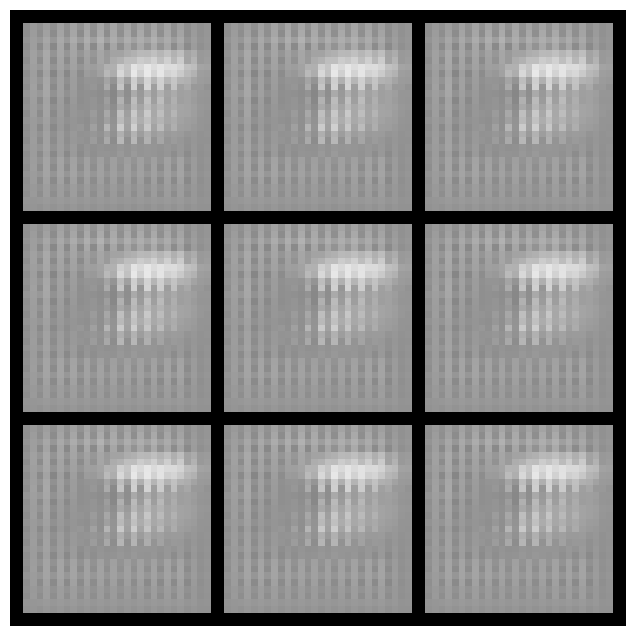

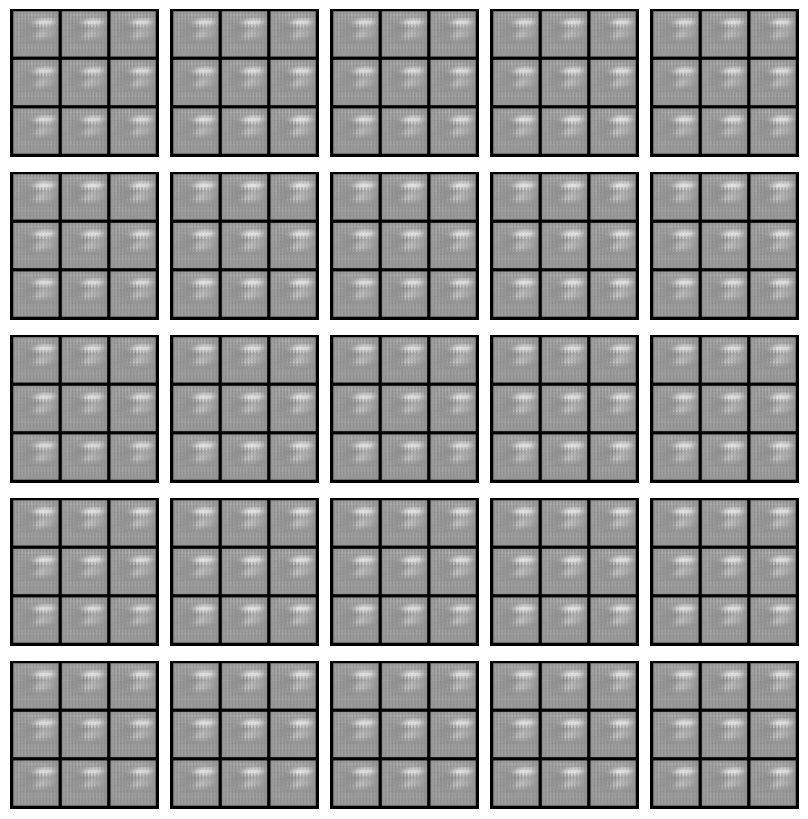

In [37]:
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 8 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
plot_numbers = [2, 3, 4, 5, 7]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

#### Cambiar el vector de ruido
Ahora, ¿qué pasa si mantienes la clase constante, pero en su lugar cambias el vector de ruido? También podemos interpolar el vector de ruido y generar una imagen en cada paso.

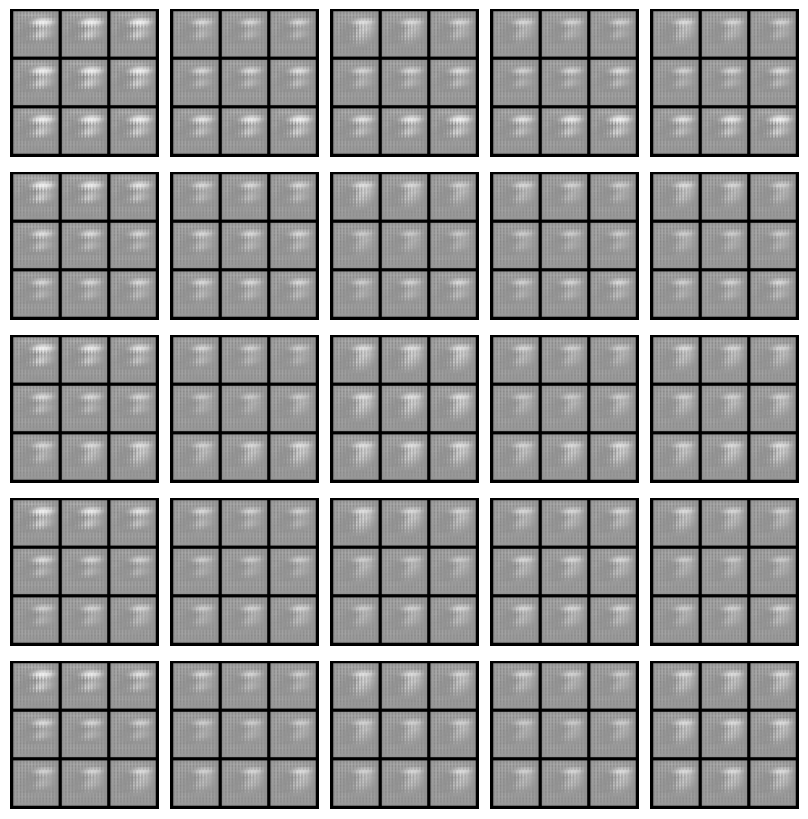

In [38]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([6]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

## Cargar y probar modelos salvados

In [39]:
# Creating exactly the same model, and to device
gen2 = Generator(input_dim=generator_input_dim).to(device)
gen2.load_state_dict(torch.load('Conditional_GAN_MNIST_Gen.pt'))

# Only Generator is necessary to see new samples, but loading discriminator too
disc2 = Discriminator(im_chan=discriminator_im_chan).to(device)
disc2.load_state_dict(torch.load('Conditional_GAN_MNIST_Disc.pt'))


FileNotFoundError: [Errno 2] No such file or directory: 'Conditional_GAN_MNIST_Gen.pt'

## Exploración con los modelos cargados

Una vez cargados los modelos preentrenados, podemos usarlos exactamente igual que los originales, pudiendo explorar los cambios en la clase o el vector de ruido

#### Cambiando el vector de Clase

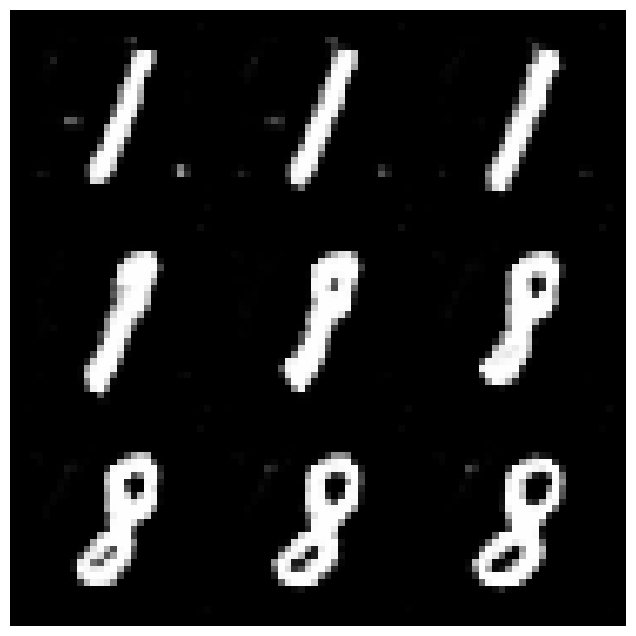

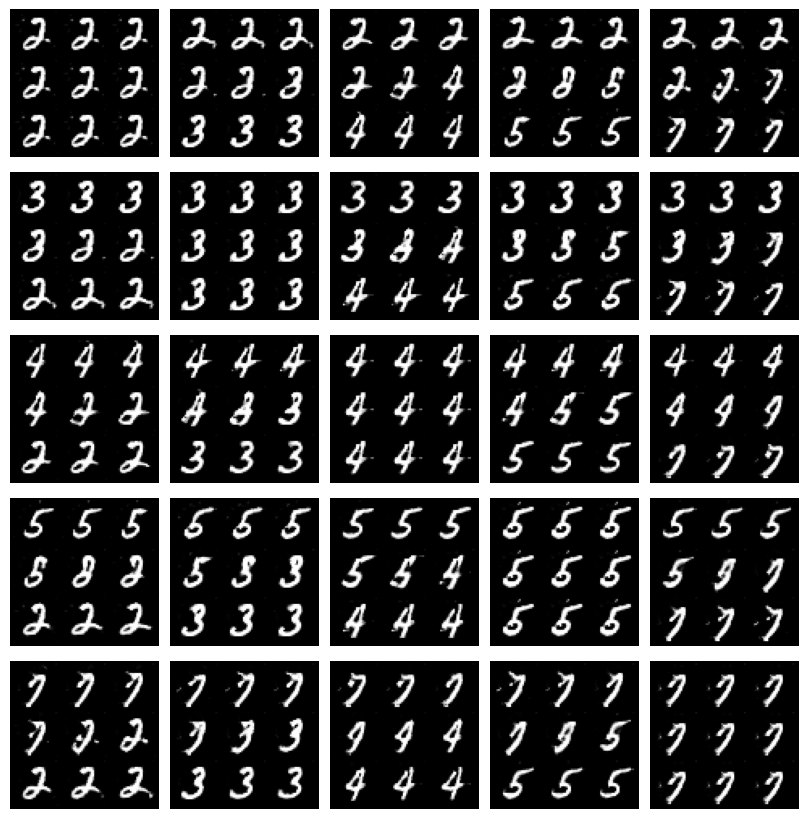

In [ ]:
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen2(noise_and_labels)  ## GENERATOR MODEL !!
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 8 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
plot_numbers = [2, 3, 4, 5, 7]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

#### Cambiar el vector de ruido

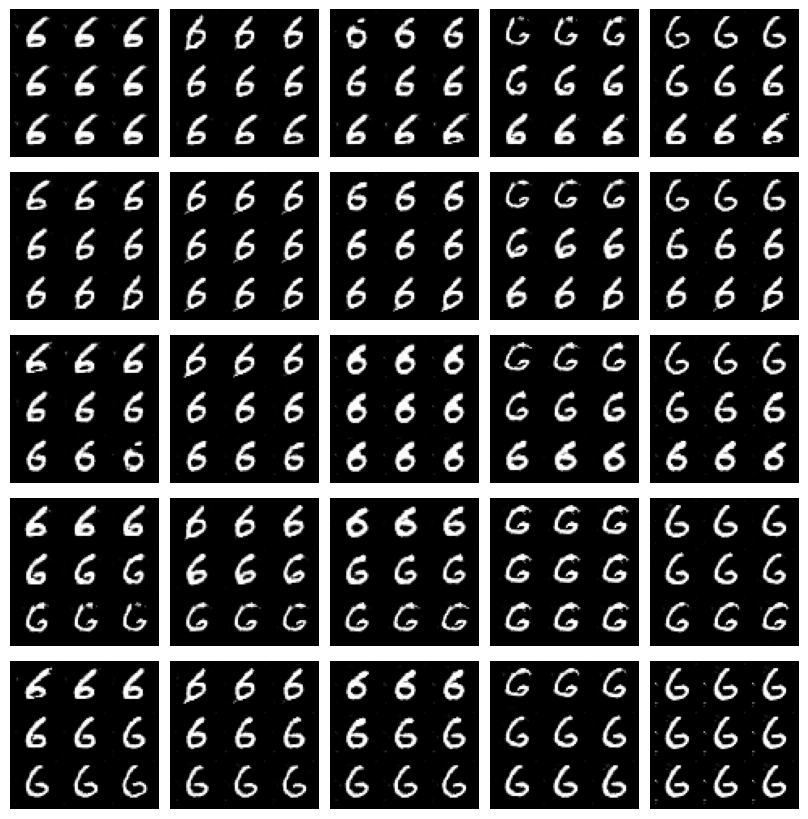

In [ ]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([6]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen2(noise_and_labels)   ## GENERATOR MODEL !!
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

##Referencias

+ Notebook basado en ejercicios de [DeepLearning.AI](https://www.deeplearning.ai/)
+ Documentación de [PyTorch](https://pytorch.org/docs/stable/index.html)

# EOF